linear regression

In [1]:
import os
import json
import codecs
import numpy as np
from math import log10
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression as LR
from scipy.stats import spearmanr, pearsonr, gaussian_kde

In [2]:
class CalibratorFactory(object):
    def __call__(self, valid_preacts, valid_labels):
        raise NotImplementedError()

class LinearRegression(CalibratorFactory):
    def __init__(self, verbose=True):
        self.verbose = verbose 

    def __call__(self, valid_preacts, valid_labels):
        lr = LR().fit(valid_preacts.reshape(-1, 1), valid_labels)
    
        def calibration_func(preact):
            return lr.predict(preact.reshape(-1, 1))

        return calibration_func

load the data

In [3]:
flankToCbf1Ddg = {}
flankToPho4Ddg = {}
firstLine = True
allFlanks = []
with open("data/experimental/all_predicted_ddGs.csv") as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        flank, Cbf1_ddg, Pho4_ddg = line.strip().split(',')
        flankToCbf1Ddg[flank] = float(Cbf1_ddg)
        flankToPho4Ddg[flank] = float(Pho4_ddg)
        allFlanks.append(flank)

In [4]:
flankToSig = {}
firstLine = True
with open("data/experimental/44k_Cbf1_validation.txt") as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        flankToSig[line.strip().split('\t')[1]] = log10(float(line.strip().split('\t')[2]))

In [5]:
obj_text1 = codecs.open("data/preds/pbexo.pho4.flankToDeltaLogCount.json", 'r', encoding='utf-8').read()
flankToPho4CountPreds = json.loads(obj_text1)

In [6]:
obj_text2 = codecs.open("data/preds/limited.cbf1.eth.logCounts_fixed_min.json", 'r', encoding='utf-8').read()
flankToCbf1CountPreds = json.loads(obj_text2)

In [7]:
obj_text3 = codecs.open("data/preds/limited.cbf1.eth.logCounts_PBM_fixed_min.json", 'r', encoding='utf-8').read()
flankToCbf1PBMCountPreds = json.loads(obj_text3)

sampling and processing

In [8]:
pbmRepeatFlanksSigs = {}
pbmRepeatFlanksPreds = {}
for key in flankToSig.keys():
    if key[10:15]+key[21:26] not in pbmRepeatFlanksSigs:
        pbmRepeatFlanksSigs[key[10:15]+key[21:26]] = []
        pbmRepeatFlanksPreds[key[10:15]+key[21:26]] = []
    pbmRepeatFlanksSigs[key[10:15]+key[21:26]].append(flankToSig[key])
    pbmRepeatFlanksPreds[key[10:15]+key[21:26]].append(float(flankToCbf1PBMCountPreds[key]))
pbmFlanksDdGs = {}
pbmFlanksSigs = {}
pbmFlanksPredsAvg = {}
for key in pbmRepeatFlanksSigs.keys():
    pbmFlanksDdGs[key] = -flankToCbf1Ddg[key]
    pbmFlanksSigs[key] = np.mean(np.array(pbmRepeatFlanksSigs[key]), axis = 0)
    pbmFlanksPredsAvg[key] = np.mean(np.array(pbmRepeatFlanksPreds[key]), axis = 0)

In [9]:
sampled_valid_pbm_keys = np.random.choice(list(pbmFlanksSigs.keys()), 2000, replace=False)
sampled_pbm_keys = list(pbmFlanksSigs.keys())

In [10]:
sampled_valid_keys = np.random.choice(allFlanks, 5000, replace=False)
sampled_keys = np.random.choice(allFlanks, 50000, replace=False)

In [11]:
samplePho4CountPreds = {}
for key in sampled_valid_keys:
    y_0 = np.array(flankToPho4CountPreds[key][0]).astype(float)
    y_1 = np.array(flankToPho4CountPreds[key][1]).astype(float)
    samplePho4CountPreds[key] = np.mean(y_1-y_0)
for key in sampled_keys:
    y_0 = np.array(flankToPho4CountPreds[key][0]).astype(float)
    y_1 = np.array(flankToPho4CountPreds[key][1]).astype(float)
    samplePho4CountPreds[key] = np.mean(y_1-y_0)

plotting code

In [12]:
%matplotlib inline

def plotCorrs(xvals, yvals, xlabel, ylabel):
    xy = np.vstack([xvals,yvals])
    z = gaussian_kde(xy)(xy)
    smallFont = {'size' : 10}
    plt.rc('font', **smallFont)
    fig, ax = plt.subplots()
    ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title("correlation: "+str(pearsonr(xvals, yvals)))
    plt.show()

count to -ddG  (Pho4 PBexo)

In [13]:
valid_preacts = []
valid_labels = []
for key in sampled_valid_keys:
    valid_preacts.append(samplePho4CountPreds[key])
    valid_labels.append(-flankToPho4Ddg[key])
valid_preacts = np.array(valid_preacts)
valid_labels = np.array(valid_labels)

In [14]:
preacts = []
labels = []
for key in sampled_keys:
    preacts.append(samplePho4CountPreds[key])
    labels.append(-flankToPho4Ddg[key])
preacts = np.array(preacts)
labels = np.array(labels)

In [15]:
lr = LinearRegression()
calibration_func = lr(valid_preacts, valid_labels)
calibrated_counts = calibration_func(preacts)

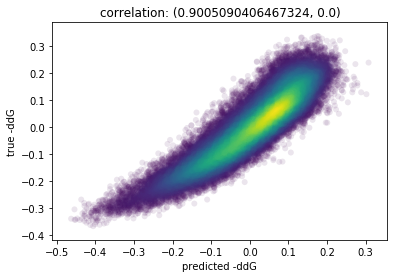

In [16]:
plotCorrs(calibrated_counts, labels, "predicted -ddG", "true -ddG")

-ddG to count  (Pho4 PBexo)

In [17]:
lr = LinearRegression()
calibration_func = lr(valid_labels, valid_preacts)
calibrated_counts = calibration_func(labels)

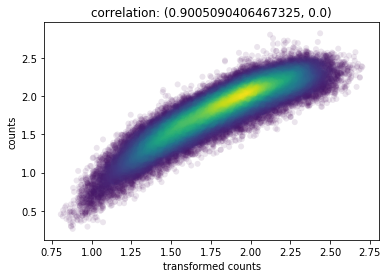

In [18]:
plotCorrs(calibrated_counts, preacts, "transformed counts", "counts")

count to -ddG  (Cbf1 ChIPexo Ethanol-Limited)

In [19]:
valid_preacts = []
valid_labels = []
for key in sampled_valid_keys:
    valid_preacts.append(float(flankToCbf1CountPreds[key]))
    valid_labels.append(-flankToCbf1Ddg[key])
valid_preacts = np.array(valid_preacts)
valid_labels = np.array(valid_labels)

In [20]:
preacts = []
labels = []
for key in sampled_keys:
    preacts.append(float(flankToCbf1CountPreds[key]))
    labels.append(-flankToCbf1Ddg[key])
preacts = np.array(preacts)
labels = np.array(labels)

In [21]:
lr = LinearRegression()
calibration_func = lr(valid_preacts, valid_labels)
calibrated_counts = calibration_func(preacts)

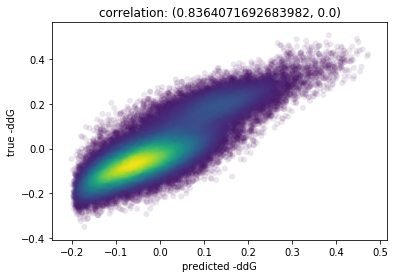

In [22]:
plotCorrs(calibrated_counts, labels, "predicted -ddG", "true -ddG")

-ddG to count  (Cbf1 ChIPexo Ethanol-Limited)

In [23]:
lr = LinearRegression()
calibration_func = lr(valid_labels, valid_preacts)
calibrated_counts = calibration_func(labels)

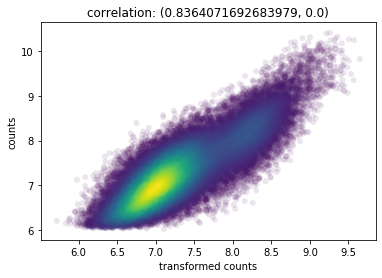

In [24]:
plotCorrs(calibrated_counts, preacts, "transformed counts", "counts")

log PBM signal to count (Cbf1 ChIPexo Ethanol-Limited)

In [25]:
valid_preacts = []
valid_labels = []
for key in sampled_valid_pbm_keys:
    valid_preacts.append(pbmFlanksSigs[key])
    valid_labels.append(pbmFlanksPredsAvg[key])
valid_preacts = np.array(valid_preacts)
valid_labels = np.array(valid_labels)

In [26]:
preacts = []
labels = []
for key in sampled_pbm_keys:
    preacts.append(pbmFlanksSigs[key])
    labels.append(pbmFlanksPredsAvg[key])
preacts = np.array(preacts)
labels = np.array(labels)

In [27]:
lr = LinearRegression()
calibration_func = lr(valid_preacts, valid_labels)
calibrated_counts = calibration_func(preacts)

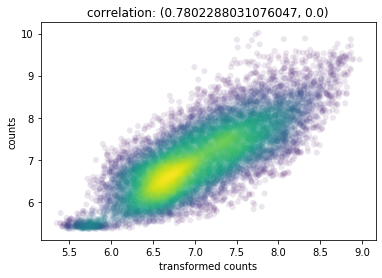

In [28]:
plotCorrs(calibrated_counts, labels, "transformed counts", "counts")

count to log PBM signal (Cbf1 ChIPexo Ethanol-Limited)

In [29]:
lr = LinearRegression()
calibration_func = lr(valid_labels, valid_preacts)
calibrated_counts = calibration_func(labels)

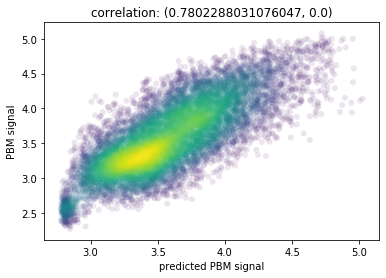

In [30]:
plotCorrs(calibrated_counts, preacts, "predicted PBM signal", "PBM signal")

PBM to -ddG (raw measurements regression)

In [31]:
valid_preacts = []
valid_labels = []
for key in sampled_valid_pbm_keys:
    valid_preacts.append(pbmFlanksSigs[key])
    valid_labels.append(pbmFlanksDdGs[key])
valid_preacts = np.array(valid_preacts)
valid_labels = np.array(valid_labels)

In [32]:
preacts = []
labels = []
for key in sampled_pbm_keys:
    preacts.append(pbmFlanksSigs[key])
    labels.append(pbmFlanksDdGs[key])
preacts = np.array(preacts)
labels = np.array(labels)

In [33]:
lr = LinearRegression()
calibration_func = lr(valid_preacts, valid_labels)
calibrated_counts = calibration_func(preacts)

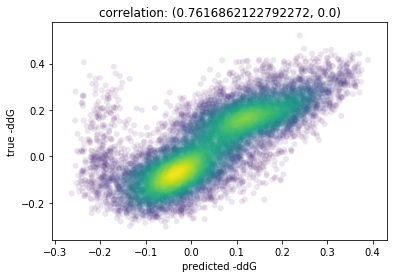

In [34]:
plotCorrs(calibrated_counts, labels, "predicted -ddG", "true -ddG")

-ddG to PBM (raw measurements regression)

In [35]:
lr = LinearRegression()
calibration_func = lr(valid_labels, valid_preacts)
calibrated_counts = calibration_func(labels)

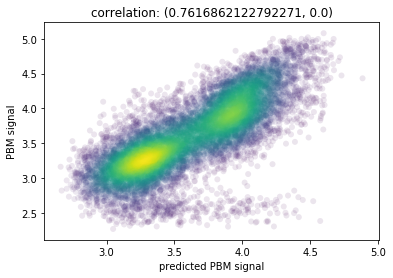

In [36]:
plotCorrs(calibrated_counts, preacts, "predicted PBM signal", "PBM signal")

PBM to count to -ddG (Cbf1 ChIPexo Ethanol-Limited)

In [37]:
valid_preacts = []
valid_labels = []
for key in sampled_valid_pbm_keys:
    valid_preacts.append(pbmFlanksSigs[key])
    valid_labels.append(pbmFlanksPredsAvg[key])
valid_preacts = np.array(valid_preacts)
valid_labels = np.array(valid_labels)

In [38]:
preacts = []
labels = []
for key in sampled_pbm_keys:
    preacts.append(pbmFlanksSigs[key])
    labels.append(pbmFlanksDdGs[key])
preacts = np.array(preacts)

In [39]:
lr = LinearRegression()
calibration_func = lr(valid_preacts, valid_labels)
calibrated_counts = calibration_func(preacts)

In [40]:
valid_preacts = []
valid_labels = []
for key in sampled_valid_keys:
    valid_preacts.append(float(flankToCbf1CountPreds[key]))
    valid_labels.append(-flankToCbf1Ddg[key])
valid_preacts = np.array(valid_preacts)
valid_labels = np.array(valid_labels)

In [41]:
lr2 = LinearRegression()
calibration_func = lr2(valid_preacts, valid_labels)
calibrated_ddGs = calibration_func(calibrated_counts)

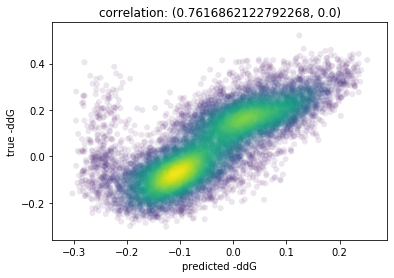

In [42]:
plotCorrs(calibrated_ddGs, labels, "predicted -ddG", "true -ddG")

-ddG to count to PBM (Cbf1 ChIPexo Ethanol-Limited)

In [43]:
valid_preacts = []
valid_labels = []
for key in sampled_valid_keys:
    valid_preacts.append(-flankToCbf1Ddg[key])
    valid_labels.append(float(flankToCbf1CountPreds[key]))
valid_preacts = np.array(valid_preacts)
valid_labels = np.array(valid_labels)

In [44]:
preacts = []
labels = []
for key in sampled_pbm_keys:
    preacts.append(pbmFlanksDdGs[key])
    labels.append(pbmFlanksSigs[key])
preacts = np.array(preacts)

In [45]:
lr = LinearRegression()
calibration_func = lr(valid_preacts, valid_labels)
calibrated_counts = calibration_func(preacts)

In [46]:
valid_preacts = []
valid_labels = []
for key in sampled_valid_pbm_keys:
    valid_preacts.append(pbmFlanksPredsAvg[key])
    valid_labels.append(pbmFlanksSigs[key])
valid_preacts = np.array(valid_preacts)
valid_labels = np.array(valid_labels)

In [47]:
lr2 = LinearRegression()
calibration_func = lr2(valid_preacts, valid_labels)
calibrated_sigs = calibration_func(calibrated_counts)

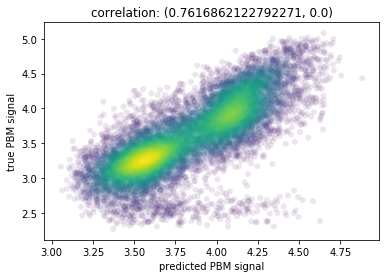

In [48]:
plotCorrs(calibrated_sigs, labels, "predicted PBM signal", "true PBM signal")